In [12]:
import numpy as np
import seaborn as sns
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import random
import math
from IPython.core.debugger import set_trace
from datetime import datetime
import sys
random.seed(datetime.now())

# How Much Information a Fault Injection Experiment Can Tell About the Resiliency of a Target Program.

How many different type of dynamic instructions you try to make fault tolerance prediction?

In [101]:
# Dataset
dataset = "lu" # current available dataset fft, lu, cg

In [130]:
path = ""
# Threshold that used to decide whether the final outcome is SDC or Masked.
threshold = 0.01

if dataset == "fft":
    path = "../static/data/fft/fft_complete"
    threshold = 0.001
elif dataset == "cg":
    path = "../static/data/cg/cg_in8"
    threshold = 0.07
elif dataset == "lu":
    path = "../static/data/lu/lu20000"
    threshold = 0.0001
# The percentage of the test experiment over exhaust fault injections.
test_experiment_percentage = 0.1

# The fault injection campaign experiment
fault_injection_campaign = pd.read_csv(path+"/injectlog.log",  sep=" ", names=['fileindex', 'file', 'linenum', 'variable','byte_num', 'corrupted','init_value','to', 'corrupt_value', 'mask', 'byte','expo', 'ss', 'op', 'diffnorm', 'empty'])



# Golden Run
golden_run = pd.read_csv(path+"/golden.log",  sep=" ", names=['file', 'linenum', 'variable', 'value'])

# Subset of fault injection campaign that used to verify the quality of a dynamic instruction
test_experiments = fault_injection_campaign.sample(frac=test_experiment_percentage, replace=False,  random_state=1)

# SDC ratio of test experiments
SDC_count = 0
for index, row in test_experiments.iterrows():
    diffnorm = float(row['diffnorm'])
    
    if diffnorm > threshold:
        SDC_count += 1

print(SDC_count/len(test_experiments))

0.32429378531073444


In [131]:
# The number of fault injection experiments that a single fault injection can predict.
def single_prediction(fault_inject_run, golden_run, fault_injections, threshold = 0.001):
    if len(fault_inject_run) < len(golden_run):
        print("Bad fault injection experiment!")
        return False
    
    crash = 0
    SDC_count = 0
    positive_prediction = 0
    negative_prediction = 0
    boundary = np.array(fault_inject_run.value[0:len(golden_run)], dtype="float") - np.array(golden_run.value, dtype="float")
    boundary = np.abs(boundary)
    
    count = 0
    
    if np.isnan(boundary).any() or np.isinf(boundary).any():
        print("This experiment outcome is masked, but the propagation process contains nan or infinity event")
        return False
    
    for index, row in fault_injections.iterrows():
        #print(index, row["byte_num"])
        instruction_index = int(row["byte_num"].split("#")[1])   
        
        
        #if instruction_index > 15000:
        #    continue
        
        count +=1
        
        inject_error = abs(float(row["corrupt_value"]) - float(row["init_value"]))
        diffnorm = float(row['diffnorm'])
        
        if inject_error <= boundary[instruction_index]:
            if diffnorm < threshold:
                positive_prediction += 1
            elif math.isnan(diffnorm) or math.isinf(diffnorm):
                crash += 1
            else:
                negative_prediction += 1     
    
    if (positive_prediction + negative_prediction) is 0:
        #return {"crash":crash/len(fault_injections), "positive": positive_prediction/len(fault_injections), "negative": negative_prediction/len(fault_injections), "accuracy":0}   
        return {"crash":crash/count, "positive": positive_prediction/count, "negative": negative_prediction/count, "accuracy":0}    
    else:
        #return {"crash":crash/len(fault_injections), "positive": positive_prediction/len(fault_injections), "negative": negative_prediction/len(fault_injections), "accuracy":positive_prediction/(positive_prediction + negative_prediction)}
        return {"crash":crash/count, "positive": positive_prediction/count, "negative": negative_prediction/count, "accuracy":positive_prediction/(positive_prediction + negative_prediction+crash)}    

##  Randomly select 1000 fault injection experiments and test the prediction accuracy of each masked experiment.

In [132]:
len(fault_injection_campaign)

17700

In [133]:
diffnorm = np.array(fault_injection_campaign.diffnorm, dtype='float')
length = len(fault_injection_campaign)
list_indexs = []

for i in range(1000):
    print(i)
    index = random.randint(0, len(fault_injection_campaign))
    norm = diffnorm[index]
    pre_res = []
    fault_inject_run = pd.read_csv(path+"/appstate_"+str(index)+".log",  sep=' ', names=['file', 'linenum', 'variable', 'value'])
    
    #verify the select fault injection experiment is valuable
    if norm < threshold and norm != 0 and not np.isinf(norm):
        pre_res = single_prediction(fault_inject_run, golden_run, test_experiments, threshold)
        if not pre_res:
            continue
            
        list_indexs.append({"diffnorm":math.log10(norm), "index":i, "negative":pre_res["negative"], "positive":pre_res["positive"], 'accuracy':pre_res['accuracy']})

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [134]:
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
fig = plt.figure()
list_indexs = sorted(list_indexs, key = lambda i: i['diffnorm']) 
x = []
y = []
z = []
k = []
for i in range(len(list_indexs)):
    x.append(list_indexs[i]['diffnorm'])
    y.append(list_indexs[i]['positive'])
    z.append(list_indexs[i]['negative'])
    k.append(list_indexs[i]['accuracy'])

Text(0.5,0,'Diffnorm(log10)')

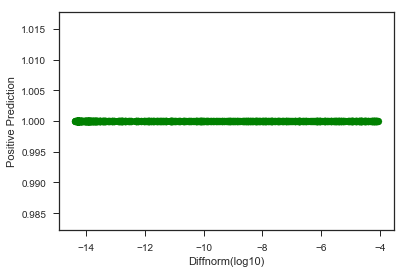

In [135]:
plt.scatter(x, k, color='green')
plt.ylabel("Positive Prediction")
plt.xlabel("Diffnorm(log10)")


#print(y)

In [136]:
#plt.plot(x, z, color='red')
#plt.ylabel("Negative Prediction")
#plt.xlabel("Diffnorm(log10)")
#sns

#print(k)

Text(0.5,0,'prediction accuracy')

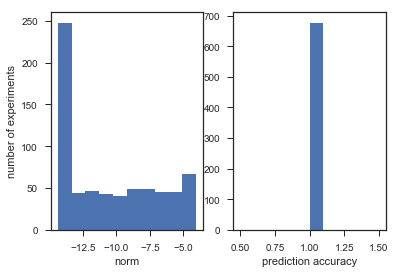

In [137]:
#plt.plot(x, k, color='orange')
#plt.ylabel("Prediction Accuracy")
#plt.xlabel("Diffnorm(log10)")
sns.set(style="ticks")
sns.axes_style('white')
df = pd.DataFrame(data = {"x":x, "y":k})
#sns.scatterplot(x = df['x'], y = df['y']);
#sns.distplot(df.x)
plt.subplot(1, 2, 1)
plt.hist(df.x)
plt.xlabel('norm')
plt.ylabel('number of experiments')

#sns.distplot(df.x)

plt.subplot(1, 2, 2)
plt.hist(df.y)
plt.xlabel('prediction accuracy')
#sns.distplot(df.y)
#plt.hist(df.y)
#sns.kdeplot(df.x)
#sns.jointplot(x='x', y='y', kind="hex", color="#4CB391")
#with 
#    sns.jointplot("x", "y", df, kind='hex')

# The Golden Boundary of the Fault Injection Experiment

1. A bit map base boundary
2. A value scale base boundary

In the following code, the construction of the golden boundary is based on the exhuast fault injection campaign.
The method of using boundary analysis is based on the assumption that for each fault injection location, there is 
a threshold such that the inject error exceed that value will result into SDC outcome.
 
 
Using the fault injection campaign to construct the boundary is also not perfect because each location has 64 sample to estimate the threshold value

In [126]:
#dataset = "fft"

In [11]:
path = ""
# Threshold that used to decide whether the final outcome is SDC or Masked.
threshold = 0.01

if dataset == "cg":
    path = "../static/data/cg_in8.csv"
    threshold = 0.07
elif dataset == "fft":
    path = "../static/data/fft_complete.csv"
    threshold = 0.001
elif dataset == "lu":
    path = "../static/data/lu_complete.csv"
    threshold = 0.0001

fault_injection_campaign = pd.read_csv(path)
#fault_injection_campaign
#File index, Function, Line, Variable, out_xor, out_xor_relative, diffnormr, outcome, iter, bit, DI

In [12]:
masked_golden_boundary = {}
sdc_golden_boundary = {}
x = []
y = []
z = []
count = 0
for index, row in fault_injection_campaign.iterrows():
    #print(index)
    inject_error = abs(float(row["out_xor"]))
    instruction_index = row["DI"]
    norm = row["diffnormr"]
    
    #log scale the inject error
    if inject_error > 1:
        inject_error = math.log10(inject_error)
    
    #if inject_error > 20:# and norm < threshold:
    #    inject_error = 20
    #init
    
    if instruction_index not in masked_golden_boundary:
        #print(instruction_index)
        masked_golden_boundary[instruction_index] = 0
        sdc_golden_boundary[instruction_index] = 10000#sys.float_info.max
        x.append(instruction_index)
    
    #if the outcome is SDC
    if norm > threshold:
        if sdc_golden_boundary[instruction_index] > inject_error:
            sdc_golden_boundary[instruction_index] = inject_error
            count += 1
    
    #if the outcome is masked
    elif norm < threshold:
        if masked_golden_boundary[instruction_index] < inject_error:
            masked_golden_boundary[instruction_index] = inject_error
    
# plot the golden boundary
for i in x:
    y.append(masked_golden_boundary[i])
    z.append(sdc_golden_boundary[i])

print(threshold)

#plt.plot(x, y, color='green')
#plt.plot(x, z, color='red')
#plt.ylabel("Negative Prediction")
#plt.xlabel("instruction")

0.001


0.001


Text(0.5,0,'instruction')

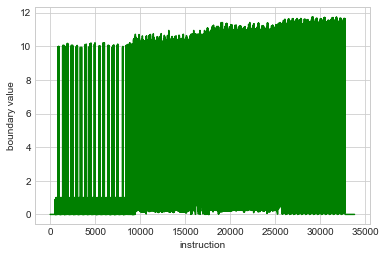

In [13]:
start = 0
end = -1

x1 = np.array(x)[start:end]
y1 = np.array(y)[start:end]
z1 = np.array(z)[start:end]

print(threshold)

plt.plot(x1, y1, color='green')
#plt.plot(x1, z1, color='red')
plt.ylabel("boundary value")
plt.xlabel("instruction")

# The standard diviation boxplot.

1. Random sample one thousand experiments and draw the standard deviation plot 

In [14]:
if dataset == "cg":
    fault_injection_campaign = pd.read_csv('../static/data/cg_in8.csv')
    path = "../static/data/cg/cg_in8"
elif dataset == "fft":
    fault_injection_campaign = pd.read_csv('../static/data/fft20000.csv')
    path = "../static/data/fft/fft_complete"
elif dataset == "lu":
    fault_injection_campaign = pd.read_csv('../static/data/lu_complete.csv')
    path = "../static/data/lu/lu_20000"

fault_injection_campaign_sampleset = fault_injection_campaign.sample(n=500, replace=False)
masked_runs = []
expected_program_length = len(golden_run)
golden_run_value = np.array(golden_run['value'], dtype='float')
    
for index, row in fault_injection_campaign_sampleset.iterrows():
    #print(row['oun,tcome'])
    #print(row['File_index'])
    if row['outcome'] == 'Masked':
        fault_inject_run = pd.read_csv(path+"/appstate_"+str(row['File_index'])+".log",  sep=' ', names=['file', 'linenum', 'variable', 'value'])
        fault_inject_run_value = np.array(fault_inject_run['value'], dtype='float')
        if len(fault_inject_run) < expected_program_length:
            continue
        masked_runs.append(np.abs(fault_inject_run_value[0:expected_program_length] - golden_run_value))
    
    
masked_runs = np.array(masked_runs)

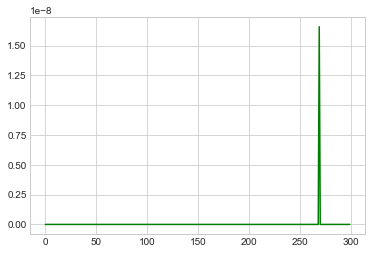

In [15]:
plt.plot(np.mean(masked_runs, axis=0)[0:300], color='green')
#plt.plot(np.std(masked_runs, axis=0)[150:350], color='orange')
#plt.plot(masked_runs[], color='black')

In [16]:
golden_run_path = "../static/data/cg/cg_in8/golden.log"
golden_run = pd.read_csv(golden_run_path,  sep=' ', names=['file', 'linenum', 'variable', 'value'], header=0)
golden_run_value = np.array(golden_run.value, dtype='float')
cg_fault_injection = pd.read_csv("../static/data/cg_in8.csv")
SIZE = len(cg_fault_injection)

# Experiment 1 -- CG
Take all the fault injections in the inital condition. Find all the fault injection cases that result into masked. For each masked case, compare error run with the golden run to get a error run curve. Combine all the error run curve to construct a error boundary for masked and SDC.

In [25]:
cg_fault_injection_experiment = pd.read_csv('matrix/in10_data/in10/injectlog.log',  sep=' ', names=['file', 'linenum', 'variable','byte_num', 'corrupted','init_value','to', 'corrupt_value', 'mask', 'byte','expo', 'ss', 'op', 'diffnorm', 'empty'])

FileNotFoundError: File b'matrix/in10_data/in10/injectlog.log' does not exist

### SDC Ratio over entire program

In [ ]:
iters = list(cg_fault_injection.iter)
iters.reverse()
count  = 0
last_zero_iteration_index = SIZE - iters.index(0)
dynamic_step_to_record_computation_result = int(last_zero_iteration_index/64)

for i in range(last_zero_iteration_index, len(iters)):
    if cg_fault_injection.outcome[i] == "SDC":
        count += 1

print("SDC ratio over entire program: ", count/len(iters))

In [ ]:
#only tracking the maximum value of the masked run after this time step.
tracking_length = len(golden_run_value)

def construct_boundary(number_of_dynamic_instruction):
    boundary = []
    ground_truth = {"Masked": 0, "SDC":0, "DUE":0}

    for i in range(tracking_length):
        boundary.append({'max':0, 'min':0})

    for i in range(number_of_dynamic_instruction):
        index = int(random.random() * SIZE)
        
        ground_truth[cg_fault_injection.outcome[index]] += 1
        
        if cg_fault_injection.outcome[index] == "Masked":
            masked_run_path = "cg_simulation/appstate_"+ str(index)+".log" 

            #Check whether the tracking file is on the path
            #TODO: check whether can regenerate the data
            if not os.path.isfile(masked_run_path):
                continue

            masked_run = pd.read_csv(masked_run_path,  sep=",", names=['file', 'linenum', 'variable', 'value'], header=0)
            masked_run_value = np.array(masked_run.value, dtype='float')
            
            #This is a werid information in the data.
            #TODO: may check why such outcome is shown
            if len(masked_run_value) < tracking_length:
                print("odd!")
                continue
            
            #array contain NAN, ignore the run
            if np.isnan(np.min(masked_run_value)):
                continue
            
            comparision_result = masked_run_value[0:tracking_length] - golden_run_value
        else:
            continue
        
        
        for j in range(dynamic_step_to_record_computation_result, tracking_length):
            if comparision_result[j] > boundary[j]['max'] and comparision_result[j] >= 0:
                boundary[j]['max'] = comparision_result[j]

            if comparision_result[j] < boundary[j]['min'] and comparision_result[j] < 0:
                boundary[j]['min'] = comparision_result[j]
                
    return [boundary, ground_truth]

def predict(boundary):
    masked_true_positive = 0
    masked_false_positive = 0
    sdc_true_positive = 0
    sdc_false_positive = 0
    result = {}

    for i in range(last_zero_iteration_index + 1, SIZE):
        index = math.floor(i/64)
        if cg_fault_injection.out_xor[i] < boundary[index]['max'] and cg_fault_injection.out_xor[i] > boundary[index]['min']:
            if cg_fault_injection.outcome[i] == "Masked":
                masked_true_positive += 1
            else:
                masked_false_positive += 1
        else:
            if cg_fault_injection.outcome[i] == "SDC":
                sdc_true_positive += 1
            else:
                sdc_false_positive += 1

    result["predict masked case"] =  (masked_true_positive + masked_false_positive)/SIZE
    result["predict SDC case"] = (sdc_true_positive + sdc_false_positive)/SIZE
    result["masked prediction accuracy"] = masked_true_positive/(masked_true_positive + masked_false_positive)
    result["SDC prediction accuracy"] = sdc_true_positive/(sdc_true_positive + sdc_false_positive)
    
    return result

## Can we think this as a lable propagation problem?

In [ ]:
experiments = []

ground_truth = []

for i in range(10):
    print(i)
    boundary = construct_boundary(2000)    
    experiments.append(predict(boundary[0]))
    ground_truth.append(boundary[1])

    
uniform_test = []
intuition = []

for i in range(10):
    intuition.append(experiments[i]['predict SDC case'])
    uniform_test.append(ground_truth[i]['SDC']/2000)

print(np.mean(intuition))
print(intuition)
print(np.mean(uniform_test))

# Experiment 2 -- FFT

In [ ]:
path = "../static/data/cg/cg_in8/"
golden_run_path = path+"golden.log"
golden_run = pd.read_csv(golden_run_path,  sep=' ', names=['file', 'linenum', 'variable', 'value'])
golden_run_value = np.array(golden_run.value, dtype='float')
fault_injection_experiment = pd.read_csv(path+'injectlog.log',  sep=' ', names=['file', 'linenum', 'variable','byte_num', 'corrupted','init_value','to', 'corrupt_value', 'mask', 'byte','expo', 'ss', 'op', 'diffnorm', 'empty'])
SIZE = len(fault_injection_experiment)
threshold = 0.001

In [ ]:
def load_data(path):
    
    golden_run_path = path + "golden.log"
    golden_run = pd.read_csv(golden_run_path,  sep=' ', names=['file', 'linenum', 'variable', 'value'])
    golden_run_value = np.array(golden_run.value, dtype='float')
    fault_injection_experiment = pd.read_csv(path+"injectlog.log",  sep=' ', names=['file', 'linenum', 'variable','byte_num', 'corrupted','init_value','to', 'corrupt_value', 'mask', 'byte','expo', 'ss', 'op', 'diffnorm', 'empty'])
    
    return [golden_run,fault_injection_experiment]

def SDC_ratio(experiments): 
    sdc_count = 0
    for i in range(0, len(experiments)):
        if float(experiments.diffnorm[i]) > threshold:
            sdc_count += 1
    
    return sdc_count / len(experiments)

def getBoundary(golden_run, percent, experiments, path):
    boundary = []
    nums = int(len(experiments) * percent)
    
    print(nums)

    for i in range(len(golden_run)):
        boundary.append({"min": 0, "max":0})

    for i in range(nums):
        
        diffnorm = float(experiments.diffnorm[i])
        if diffnorm > threshold or math.isnan(diffnorm) or math.isinf(diffnorm):
            continue
        
        index = int(random.random() * len(experiments))

        file_path = path+"appstate_"+str(index)+".log"
    
        fault_inject_run = pd.read_csv(file_path,  sep=' ', names=["file", "linenum", "variable", "value"])
    
        if len(fault_inject_run) < len(golden_run):
            print("weird!")
            continue
    
        values = np.array(fault_inject_run.value[0:len(golden_run)], dtype="float") - np.array(golden_run.value, dtype="float")
    
        for j in range(len(golden_run)):              
            
            if values[j] >= 0 and values[j] > boundary[j]["max"]:
                boundary[j]["max"] = values[j]
                       
            if values[j] < 0 and values[j] < boundary[j]["min"]:
                boundary[j]["min"] = values[j] 
    
    return boundary

def prediction(experiments, boundary, threshold=0.001):
    positive_prediction = 0
    negative_prediction = 0
    crash = 0
    length = len(experiments)
    
    for i in experiments.fileindex:
        index = math.floor(i/64)
        
        #print(i)
        
        inject_error = float(experiments.corrupt_value[i]) - float(experiments.init_value[i])
    
        if(inject_error > boundary[index]["min"] and inject_error < boundary[index]["max"]):
            if float(experiments.diffnorm[i]) < threshold:
                positive_prediction += 1
            elif math.isnan(float(experiments.diffnorm[i])) or math.isinf(float(experiments.diffnorm[i])):
                crash += 1
            else:
                negative_prediction += 1
    return {"positive": positive_prediction/len(experiments), "negative": negative_prediction/len(experiments), "Crash": crash/len(experiments)}

# Predict Result of 20 x 20 Matrix

In [ ]:
#golden_run, experiments = load_data(path)
#boundary = getBoundary(golden_run, 0.0001, experiments, path)
#experiments = pd.read_csv("../static/data/cg/cg_in8/injectlog.log",  sep=' ', names=['file', 'linenum', 'variable','byte_num', 'corrupted','init_value','to', 'corrupt_value', 'mask', 'byte','expo', 'ss', 'op', 'diffnorm', 'empty'])
#print(len(experiments))

# Using 6400 fault injections run in FFT to test the masked case. 

In [ ]:
boundary = []

for i in range(len(golden_run)):
    boundary.append({"min": 0, "max":0})

for i in range(8400):
    
    if fault_injection_experiment.diffnorm[i] > 0.07:
        continue
    
    index = int(random.random() * len(fault_injection_experiment))

    file_path = "matrix/in27_data/in27/appstate_"+str(index)+".log"
    
    fault_inject_run = pd.read_csv(file_path,  sep=' ', names=["file", "linenum", "variable", "value"])
    
    if len(fault_inject_run) < len(golden_run):
        print("weird!")
        continue
    
    values = np.array(fault_inject_run.value[0:len(golden_run)], dtype="float") - np.array(golden_run.value, dtype="float")
    
    for j in range(len(golden_run)):
        if values[j] >= 0 and values[j] > boundary[j]["max"]:
            boundary[j]["max"] = values[j]
                       
        if values[j] < 0 and values[j] < boundary[j]["min"]:
            boundary[j]["min"] = values[j] 

In [ ]:
positive_prediction = 0
negative_prediction = 0
for i in range(len(fault_injection_experiment.diffnorm)):
    
    index = math.floor(i/64)
    
    #if i%64 <= 52:
    #    continue
    
    inject_error = float(fault_injection_experiment.corrupt_value[i]) - float(fault_injection_experiment.init_value[i])
    
    if(inject_error > boundary[index]["min"] and inject_error < boundary[index]["max"]):
        if fault_injection_experiment.diffnorm[i] < 0.07:
            positive_prediction += 1
        else:
            negative_prediction += 1

In [ ]:
#relative error and absolute error
#for i in range(len(golden_run_value)):
#   if golden_run_value[i] != 0:
#        absolute = abs(golden_run_value[i] -  masked_run_value[i])

false_positive = 0
true_positive = 0
unsure = 0
total = (811 - 160) * 64
for i in range(160, 811):
    diff = abs(golden_run_value[i] -  masked_run_value[i]) 
    for b in range(64):
        if diff > abs(cg_fault_injection.out_xor[i * 64 + b]) and cg_fault_injection.outcome[i * 64 + b] != "Masked":
            #print(cg_fault_injection.diffnormr[i * 64 + b], cg_fault_injection.Variable[i * 64 + b], (diff - abs(cg_fault_injection.out_xor[i * 64 + b])))
            false_positive += 1
            print(i * 64 + b)
        elif diff > abs(cg_fault_injection.out_xor[i * 64 + b]) and cg_fault_injection.outcome[i * 64 + b] == "Masked":
            true_positive += 1
        else:
            unsure += 1
    
    #sdc_diff = abs(golden_run_value[i] -  sdc_run_value[i])
    #for b in range(64):
    #    if sdc_diff < abs(cg_fault_injection.out_xor[i * 64 + b]) and cg_fault_injection.outcome[i * 64 + b] != "SDC":
    #        false_positive += 1
    #    elif sdc_diff < abs(cg_fault_injection.out_xor[i * 64 + b]) and cg_fault_injection.outcome[i * 64 + b] == "SDC":
    #        true_positive += 1
    #    else:
    #        unsure +=1
            
print(false_positive/total)
print(true_positive/total)
print(unsure/total)
    
#print(i, cg_fault_injection.Variable[i], cg_fault_injection.out_xor[i], cg_fault_injection.outcome[i])
#for i in range(243*64,244*64):
#    print(i,cg_fault_injection.Variable[i], cg_fault_injection.out_xor[i], cg_fault_injection.outcome[i])
#print(golden_run_value[243])
#print(len(cg_fault_injection))
#golden_run_value-error_run_value[0:811]

In [ ]:
number_of_instructions = {}

propagation_path = []

for index in range(100):
    if index in[15731, 16246, 17523]:
        continue
    
    file_path = "cg_simulation/appstate_"+str(index)+".log"
    error_run = pd.read_csv(file_path,  sep=' ')
    
    
    #For different fault injection case, what is the number of different execution dynamic instructions
    if len(error_run) in number_of_instructions:
        number_of_instructions[len(error_run)] += 1
    else:
        number_of_instructions[len(error_run)] = 1
        
    #
    index = min(len(golden_run), len(error_run))
    #result = np.array(golden_run.value, dtype=float)[:index] - np.array(error_run.value, dtype=float)[:index]
    #propagation_elements = golden_run.line[np.where(result != 0)[0]]
    
    #path = "=>"
    #number_of_propagation_element = 5
    #for e in propagation_elements:
    #    if str(e) not in path:
    #        path += str(e)
    #        path += "=>"
    #        number_of_propagation_element -= 1
        
    #    if number_of_propagation_element == 0:
    #        break
    #if path not in propagation_path:
    #    propagation_path.append(path)

## What is the probability of the different number of storing dynamic instructions.
## What is the probability of SDC.

It's expected that if the program ends early, then there an unexpected crash during the program execution in the earlier stage. At the same time, if the program has more execution than it expected. It will have high chance causes silent data corruption.

In [ ]:
cg_outcome = cg_fault_injection['outcome'].value_counts()

print(cg_outcome)
print(sum(cg_outcome))
#propagation_path

In [ ]:
number_of_instructions

# If you want to rewrite your code.

4. interactive fault injection campaign.

### 1. A sensitive analysis across the whole program with a mapping framework.
A desity scatter plot to understand the input and output sensitivity of the program. User can selective choose the high sensitive data and mapping back to the original visualization.
    
    a. how many clusters in the plot.
    
    b. Where is each of them comes from. 
    
    c. The sample that comes from the fault injection in same location.

#### 2. Explore function level resiliency of the program. What's the difference compare to the source code level?

    a.Explore the resiliency of different program component. Aggregate the data in variable level


#### 3. How to measure the impact of one variable/function over the other?
 


# The number of times a function is called.

In [ ]:
counter = {}

line_to_func = {167:'readA', 175:'readB', 33:'waxpby', 25:'matvec', 48:'dot_r2', 75:'solve_cg', 76:'solve_cg',87:'solve_cg',57:'dot', 90:'solve_cg',91:'solve_cg',40:"daxpby", 82:'daxpby',83:'daxpby',84:'daxpby'}

for index, row in golden_run.iterrows():
    key = line_to_func[row['line']]
    if key not in counter:
        counter[key] = 1
    else:
        counter[key] += 1

In [ ]:
number_of_instruction = sum(list(counter.values()))
for item in counter.items():
    print(item[0], item[1]/number_of_instruction * 100)

# Error Propagation Analysis in one program component.

In [ ]:
golden_run_path = "cg_simulation/golden.log"
golden_run = pd.read_csv(golden_run_path,  sep=' ', names=['file', 'linenum', 'variable', 'value'])
golden_run_value = np.array(golden_run.value)
##### this is a very interesting but werid case
##### There is a NAN occur during the computation, but the  error is masked at the end.
#index_range = [17341, 24381]

##### cg p_ap_dot first interation 64 experiment
#index_range = [15552, 15603]

#file_path = "cg_simulation1/appstate_"+str(17341)+".log"
#error_run = pd.read_csv(file_path,  sep=' ')

#for i in range(len(error_run.value)):
#    print(error_run.line[i], error_run.variable[i], error_run.value[i])
#print(len(error_run.value))

#print(error_run)
#data_set = {}


#golden_run_value = np.array(golden_run.value[0:800], dtype='float')

#for index in range(index_range[0], index_range[1]+1):
#    file_path = "cg_simulation/appstate_"+str(index)+".log"
#    error_run = pd.read_csv(file_path,  sep=' ', names=['file', 'linenum', 'variable', 'value'])

#    data_set[index] = golden_run_value - np.array(error_run.value[0:800], dtype='float')


##### a specific case line 75 case 10290
##### a specific case line 75 case 10296
indexs =  [10290, 10274]# 10288] #10297]# 10296, 10289]

delta_x = [65536, 1.0]# 1321922331132047.5]#, -307779.3308780107]
x_data = range(0, 811, 1)

for index,item in enumerate(indexs): 
    file_path = "cg_simulation/appstate_"+str(item)+".log"
    error_run = pd.read_csv(file_path,  sep=' ', names=['file', 'linenum', 'variable', 'value'])
    error_run_value = np.array(error_run.value)

    sensitivity_val = (error_run_value[0:811] - golden_run_value[0:811])/delta_x[index]
    sns.lineplot(x=x_data, y=sensitivity_val, sort=False, lw=1)
    
print(sensitivity_val.argmax())

In [ ]:
#for index in range(index_range[0], index_range[1]+1):
#    print(len(data_set[index].values))
#data_set[index] = golden_run.values - error_run.values   


x_data = range(0,811,1)
sns.lineplot(x=x_data, y=sensitivity_val, sort=False, lw=1)

#for index in range(index_range[0], index_range[0]+20): 
#    sns.lineplot(x=x_data, y=data_set[index], sort=False, lw=1)

## What role the truncation error is playing in the propagation analysis
## What's the threshold of different program components.
## How much error is masked by the truncate error and How much error is masked by the model feature